In [1]:
import pandas as pd
import numpy as np
import string

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers, metrics 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, multilabel_confusion_matrix, plot_confusion_matrix
from sklearn.utils import class_weight

import pickle

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)

#Check for gpu connection
assert torch.cuda.is_available() == True
assert len(tf.config.list_physical_devices('GPU')) == 1

In [2]:
#Read in data
df = pd.read_csv('movie_train.csv', index_col=0)

df.isna().sum()
df.drop(columns = 'Cast', inplace = True)
df.reset_index(drop = True, inplace = True)
df.shape, df.isna().sum()

((10682, 5),
 Release Year    0
 Title           0
 Plot            0
 Director        0
 Genre           0
 dtype: int64)

In [ ]:
#Dependent/independent split
X = df['Plot']
y = df['Genre']

In [4]:
#Gather stop words, punctuation, numbers for removal
stop_words = spacy.lang.en.stop_words.STOP_WORDS
punctuation = [*string.punctuation , *[str(x) for x in list(range(0,10))]]

#Ensure spacy utilizes gpu over cpu
spacy.prefer_gpu()
#Load spacy
nlp = spacy.load('en_core_web_trf')

#Define spacy tokenizer
def spacy_tok(text):
    '''
    Remove punctuation, character names, and pronouns before
    lemmatizing words and removing stop words
    '''
    doc = ''.join([x for x in text if x not in punctuation])
    toks = nlp(doc)
    toks = [word for word in toks if word.pos_ != 'PROPN' and word.pos_ != 'PRON']
    toks = [word.lemma_.lower().strip() for word in toks]
    toks = [word for word in toks if word not in stop_words]
    return toks

In [4]:
#Train/Test split data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify = y,
                                                    random_state=42)

In [34]:
#Instantiate vectorizer
tfidf = TfidfVectorizer(tokenizer = spacy_tok,
                        sublinear_tf = True,
                        max_df = .8,
                        min_df = 10,
                        ngram_range = (1, 3))

In [35]:
#Tokenize/Vectorize data
X_train_feat = tfidf.fit_transform(X_train).toarray()
X_test_feat = tfidf.transform(X_test).toarray()

#Encode target variable
encoder = LabelEncoder()

encoded_y_train = encoder.fit_transform(y_train)
encoded_y_test = encoder.transform(y_test)

In [47]:
#-- Tokenizer ~15min runtime. Results saved --#

#pickle_out = open(".pickle/X_train_feat.pickle","wb")
#pickle.dump(X_train_feat, pickle_out)
#pickle_out.close()

#pickle_out = open(".pickle/X_test_feat.pickle","wb")
#pickle.dump(X_test_feat, pickle_out)
#pickle_out.close()

In [5]:
#-- Reading results back in on restart --#

#infile = open(".pickle/X_train_feat.pickle",'rb')
#X_train_feat = pickle.load(infile)
#infile.close()

#infile = open(".pickle/X_test_feat.pickle",'rb')
#X_test_feat = pickle.load(infile)
#infile.close()

In [106]:
#Instantiate baseline Naive Bayes model
mnb = MultinomialNB()

mnb.fit(X_train_feat, y_train)
y_hat = mnb.predict(X_test_feat)

#Score baseline model
f1_score(y_train, mnb.predict(X_train_feat), average = 'weighted'), f1_score(y_test, y_hat, average = 'weighted')

(0.4628830381413872, 0.36520626490896835)

In [107]:
#Gather class weights to address class imbalance in Keras model
class_weights = dict(zip(np.unique(encoded_y_train),
                         class_weight.compute_class_weight('balanced',
                                                           np.unique(encoded_y_train),
                                                           encoded_y_train)
                        )
                    ) 

In [108]:
#Configure tensorflow gpu usage
config = ConfigProto()

#gpu usage cap
#config.gpu_options.per_process_gpu_memory_fraction = .8

#Allow tensorflow to vary gpu usage
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [109]:
num = 100
batch_size = 500
#Configure optimzer learning rate
opt = tf.keras.optimizers.Adamax(learning_rate=0.00075)

#Instantiate Keras model
model = Sequential()
model.add(Dense(num*2, activation = 'relu', input_dim = X_train_feat.shape[1]))
model.add(Dropout(0.6))
model.add(Dense(num/2, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(9, activation = 'softmax'))

#Compile/fit model
model.compile(optimizer = opt,
              loss = 'sparse_categorical_crossentropy',
              metrics = [metrics.sparse_categorical_accuracy])

results = model.fit(X_train_feat, encoded_y_train,
                    epochs = 170,
                    batch_size = batch_size,
                    validation_split = .25,
                    shuffle = True,
                    class_weight = class_weights
                   )

Epoch 1/170
13/13 [==============================] - 2s 45ms/step - loss: 2.2169 - sparse_categorical_accuracy: 0.0955 - val_loss: 2.1886 - val_sparse_categorical_accuracy: 0.1258
Epoch 2/170
13/13 [==============================] - 0s 22ms/step - loss: 2.1463 - sparse_categorical_accuracy: 0.1674 - val_loss: 2.1750 - val_sparse_categorical_accuracy: 0.1638
Epoch 3/170
13/13 [==============================] - 0s 21ms/step - loss: 2.1842 - sparse_categorical_accuracy: 0.2213 - val_loss: 2.1599 - val_sparse_categorical_accuracy: 0.2287
Epoch 4/170
13/13 [==============================] - 0s 21ms/step - loss: 2.1330 - sparse_categorical_accuracy: 0.2745 - val_loss: 2.1430 - val_sparse_categorical_accuracy: 0.3140
Epoch 5/170
13/13 [==============================] - 0s 21ms/step - loss: 2.0841 - sparse_categorical_accuracy: 0.3224 - val_loss: 2.1257 - val_sparse_categorical_accuracy: 0.3390
Epoch 6/170
13/13 [==============================] - 0s 22ms/step - loss: 2.0422 - sparse_categorica

13/13 [==============================] - 0s 21ms/step - loss: 0.5555 - sparse_categorical_accuracy: 0.7783 - val_loss: 1.2369 - val_sparse_categorical_accuracy: 0.5691
Epoch 92/170
13/13 [==============================] - 0s 21ms/step - loss: 0.5447 - sparse_categorical_accuracy: 0.7794 - val_loss: 1.2332 - val_sparse_categorical_accuracy: 0.5676
Epoch 93/170
13/13 [==============================] - 0s 21ms/step - loss: 0.5386 - sparse_categorical_accuracy: 0.7934 - val_loss: 1.2309 - val_sparse_categorical_accuracy: 0.5681
Epoch 94/170
13/13 [==============================] - 0s 21ms/step - loss: 0.5332 - sparse_categorical_accuracy: 0.8060 - val_loss: 1.2285 - val_sparse_categorical_accuracy: 0.5657
Epoch 95/170
13/13 [==============================] - 0s 20ms/step - loss: 0.5127 - sparse_categorical_accuracy: 0.7957 - val_loss: 1.2253 - val_sparse_categorical_accuracy: 0.5676
Epoch 96/170
13/13 [==============================] - 0s 21ms/step - loss: 0.5212 - sparse_categorical_accur

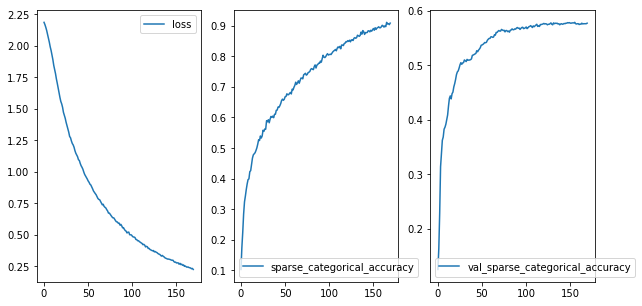

In [110]:
#Gather results
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['sparse_categorical_accuracy']
sigmoid_val_accuracy = results.history['val_sparse_categorical_accuracy']

#Plot loss and accuracy
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='sparse_categorical_accuracy')
sns.lineplot(x=results.epoch, y=sigmoid_val_accuracy, ax=ax3, label='val_sparse_categorical_accuracy');

In [111]:
test = model.predict(X_test_feat)

f1_score(encoded_y_test, test.argmax(axis=1), average = 'weighted')

0.6030469925890902

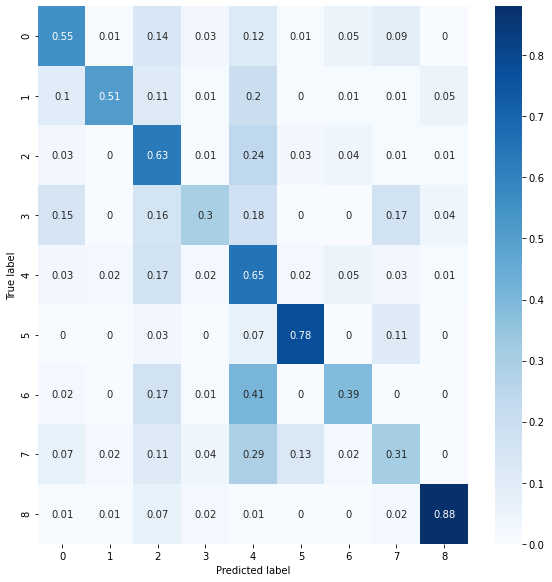

In [112]:
con_mat = tf.math.confusion_matrix(encoded_y_test,
                                   test.argmax(axis=1)).numpy()

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
#con_mat_df = pd.DataFrame(con_mat_norm,
#                     index = classes, 
#                     columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_norm, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [147]:
y.value_counts()

drama        3770
comedy       2724
horror        840
action        830
thriller      685
romance       649
western       525
adventure     331
crime         328
Name: Genre, dtype: int64

In [146]:
encoder.classes_#inverse_transform

array(['action', 'adventure', 'comedy', 'crime', 'drama', 'horror',
       'romance', 'thriller', 'western'], dtype=object)

In [243]:
encoder.inverse_transform(test.argmax(axis=1))

array(['comedy', 'action', 'drama', ..., 'romance', 'drama', 'drama'],
      dtype=object)